In [1]:
import cv2
import gc
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
import tensorflow as tf
import warnings

from itertools import chain
from PIL import Image
from skimage.io import imread, imshow, concatenate_images
from skimage.morphology import label
from skimage.transform import resize
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import *
from tqdm.notebook import trange, tqdm

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['KERAS_BACKEND']='tensorflow'

warnings.filterwarnings('ignore')
plt.style.use("ggplot")

# 影像前處理

In [3]:
# 訓練資料_Image
# 設定文件夾路徑和圖像大小
X_train_path = "C://ETT_v3/Fold1/train/"
y_train_path = "C://ETT_v3/Fold1/trainannot/"
img_size = (256, 256)

# 取得文件夾中所有的圖像檔名
X_train_names = os.listdir(X_train_path)
y_train_names = os.listdir(y_train_path)

# 初始化空的numpy陣列以儲存圖像
original_images = np.zeros((len(X_train_names), img_size[0], img_size[1], 3))
X_train = np.zeros((len(X_train_names)*2, img_size[0], img_size[1], 1))
y_train = np.zeros((len(y_train_names)*2, img_size[0], img_size[1], 1))

# 遍歷每個圖檔，使用Load_img()讀取圖檔
for i, X_name in enumerate(X_train_names):
    img = load_img(X_train_path + X_name, target_size=img_size)
    original_images[i] = img
    img_arr = np.array(img)
    img_gray = cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY)
    
    # 對比度處理 
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_clahe = clahe.apply(img_gray)
    img_clahe_reshaped = img_clahe.reshape((256, 256, 1))
    X_train[i] = img_clahe_reshaped
    
    # 水平翻轉處理
    img_flipped = cv2.flip(img_clahe_reshaped, 1).reshape((256, 256, 1))
    X_train[i+len(X_train_names)] = img_flipped

print("Image data shape:", X_train.shape)

# 訓練資料_mask
for i, y_name in enumerate(y_train_names):
    img = load_img(y_train_path + y_name, target_size=img_size)
    img_arr = np.array(img)
    img_gray = cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY).reshape((256, 256, 1))
    y_train[i] = img_gray
    
    # 水平翻轉處理
    img_flipped = cv2.flip(img_gray, 1).reshape((256, 256, 1))
    y_train[i+len(X_train_names)] = img_flipped

print("Image data shape:", y_train.shape)

Image data shape: (574, 256, 256, 1)
Image data shape: (574, 256, 256, 1)


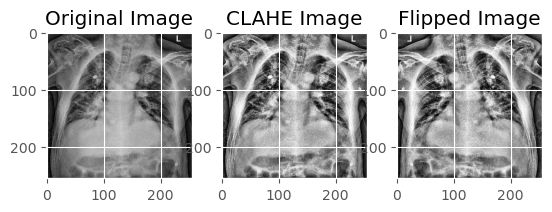

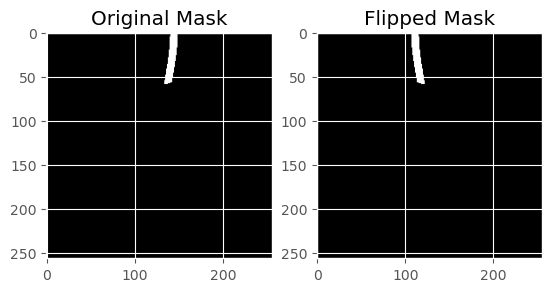

In [4]:
# 顯示原始圖像、對比強化後和水平翻轉後的圖像(第一張為例)
index = 93

plt.subplot(1, 3, 1)
plt.imshow(original_images[index].astype('uint8'))
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(X_train[index].astype('uint8'), cmap='gray')
plt.title('CLAHE Image')

plt.subplot(1, 3, 3)
plt.imshow(X_train[index+len(X_train_names)].astype('uint8'), cmap='gray')
plt.title('Flipped Image')
plt.show()

# 顯示原始mask、水平翻轉後的mask(第一張為例)
plt.subplot(1, 2, 1)
plt.imshow(y_train[index].astype('uint8'), cmap='gray')
plt.title('Original Mask')

plt.subplot(1, 2, 2)
plt.imshow(y_train[index+len(y_train_names)].astype('uint8'), cmap='gray')
plt.title('Flipped Mask')
plt.show()

In [5]:
# 驗證資料
X_val_path = "C://ETT_v3/Fold1/val/"
y_val_path = "C://ETT_v3/Fold1/valannot/"
img_size = (256, 256)

X_val_names = os.listdir(X_val_path)
y_val_names = os.listdir(y_val_path)

X_val = np.zeros((len(X_val_names)*2, img_size[0], img_size[1], 1))
y_val = np.zeros((len(y_val_names)*2, img_size[0], img_size[1], 1))

for i, X_name in enumerate(X_val_names):
    img = load_img(X_val_path + X_name, target_size=img_size)
    img_arr = np.array(img)
    img_gray = cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY)
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_clahe = clahe.apply(img_gray)
    img_clahe_reshaped = img_clahe.reshape((256, 256, 1))
    X_val[i] = img_clahe_reshaped
    
    img_flipped = cv2.flip(img_clahe_reshaped, 1).reshape((256, 256, 1))
    X_val[i+len(X_val_names)] = img_flipped

print("Image data shape:", X_val.shape)

for i, y_name in enumerate(y_val_names):
    img = load_img(y_val_path + y_name, target_size=img_size)
    img_arr = np.array(img)
    img_gray = cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY).reshape((256, 256, 1))
    y_val[i] = img_gray
    
    img_flipped = cv2.flip(img_gray, 1).reshape((256, 256, 1))
    y_val[i+len(X_val_names)] = img_flipped

print("Image data shape:", y_val.shape)

Image data shape: (94, 256, 256, 1)
Image data shape: (94, 256, 256, 1)


In [6]:
# 測試資料
X_test_path = "C://ETT_v3/Fold1/test/"
y_test_path = "C://ETT_v3/Fold1/testannot/"
img_size = (256, 256)

X_test_names = os.listdir(X_test_path)
y_test_names = os.listdir(y_test_path)

X_test = np.zeros((len(X_test_names)*2, img_size[0], img_size[1], 1))
y_test = np.zeros((len(y_test_names)*2, img_size[0], img_size[1], 1))

for i, X_name in enumerate(X_test_names):
    img = load_img(X_test_path + X_name, target_size=img_size)
    img_arr = np.array(img)
    img_gray = cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY)
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_clahe = clahe.apply(img_gray)
    img_clahe_reshaped = img_clahe.reshape((256, 256, 1))
    X_test[i] = img_clahe_reshaped
    
    img_flipped = cv2.flip(img_clahe_reshaped, 1).reshape((256, 256, 1))
    X_test[i+len(X_test_names)] = img_flipped

print("Image data shape:", X_test.shape)

for i, y_name in enumerate(y_test_names):
    img = load_img(y_test_path + y_name, target_size=img_size)
    img_arr = np.array(img)
    img_gray = cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY).reshape((256, 256, 1))
    y_test[i] = img_gray
    
    img_flipped = cv2.flip(img_gray, 1).reshape((256, 256, 1))
    y_test[i+len(X_test_names)] = img_flipped

print("Image data shape:", y_test.shape)

Image data shape: (94, 256, 256, 1)
Image data shape: (94, 256, 256, 1)


# U-Net

In [7]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [8]:
def Unet(input_img, n_filters = 2, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [9]:
K.clear_session()

input_img = Input((256, 256, 1), name='img')
model = Unet(input_img, n_filters=2, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=tf.keras.metrics.AUC())
gc.collect()

291

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 2)  20          ['img[0][0]']                    
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 256, 256, 2)  8          ['conv2d_1[0][0]']               
 rmalization)                                                                                     
                                                                                              

 ormalization)                                                                                    
                                                                                                  
 activation_13 (Activation)     (None, 64, 64, 8)    0           ['batch_normalization_13[0][0]'] 
                                                                                                  
 conv2d_transpose_2 (Conv2DTran  (None, 128, 128, 4)  292        ['activation_13[0][0]']          
 spose)                                                                                           
                                                                                                  
 concatenate_2 (Concatenate)    (None, 128, 128, 8)  0           ['conv2d_transpose_2[0][0]',     
                                                                  'activation_3[0][0]']           
                                                                                                  
 dropout_6

In [11]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-Unet.h5', verbose=1, save_best_only=True, save_weights_only=True),
    CSVLogger("Unet.csv")
]

In [12]:
results = model.fit(X_train, y_train,
                    batch_size=8,
                    epochs=20,
                    callbacks=callbacks,
                    validation_data=(X_val, y_val),
                    use_multiprocessing=True)

Epoch 1/20
72/72 [==============================] - ETA: 0s - loss: -1.6995 - auc: 0.7219
Epoch 1: val_loss improved from inf to -0.98076, saving model to model-Unet.h5
72/72 [==============================] - 5s 31ms/step - loss: -1.6995 - auc: 0.7219 - val_loss: -0.9808 - val_auc: 0.7207 - lr: 0.0010
Epoch 2/20
70/72 [============================>.] - ETA: 0s - loss: -7.8316 - auc: 0.9426
Epoch 2: val_loss improved from -0.98076 to -8.48961, saving model to model-Unet.h5
72/72 [==============================] - 2s 21ms/step - loss: -7.8677 - auc: 0.9429 - val_loss: -8.4896 - val_auc: 0.9010 - lr: 0.0010
Epoch 3/20
70/72 [============================>.] - ETA: 0s - loss: -11.7977 - auc: 0.9597
Epoch 3: val_loss did not improve from -8.48961
72/72 [==============================] - 1s 20ms/step - loss: -11.8618 - auc: 0.9599 - val_loss: -6.1675 - val_auc: 0.8803 - lr: 0.0010
Epoch 4/20
70/72 [============================>.] - ETA: 0s - loss: -16.1211 - auc: 0.9700
Epoch 4: val_loss did

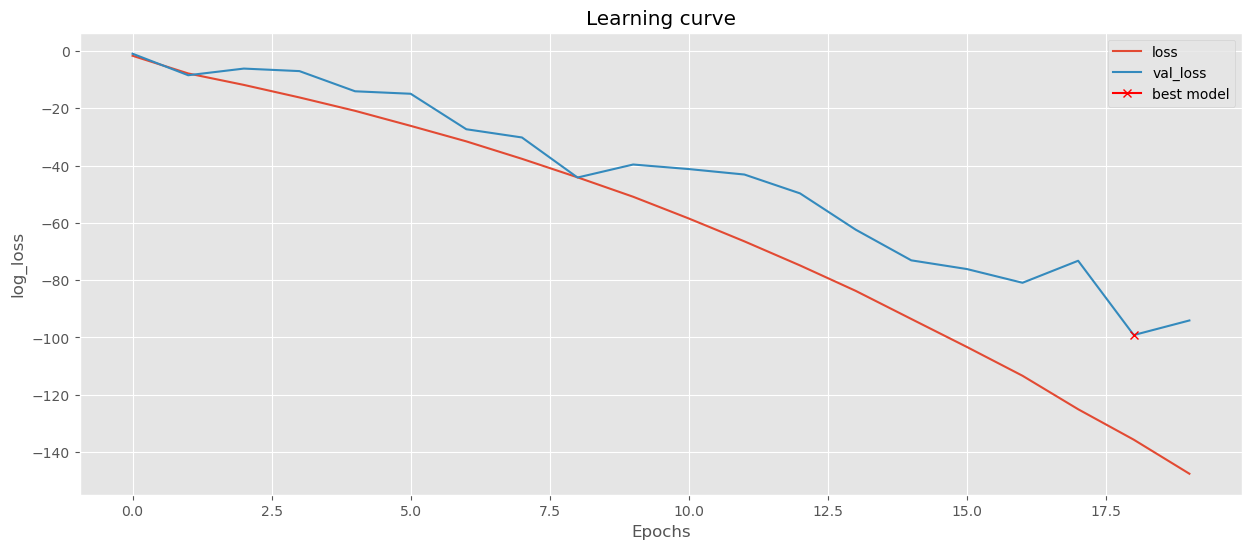

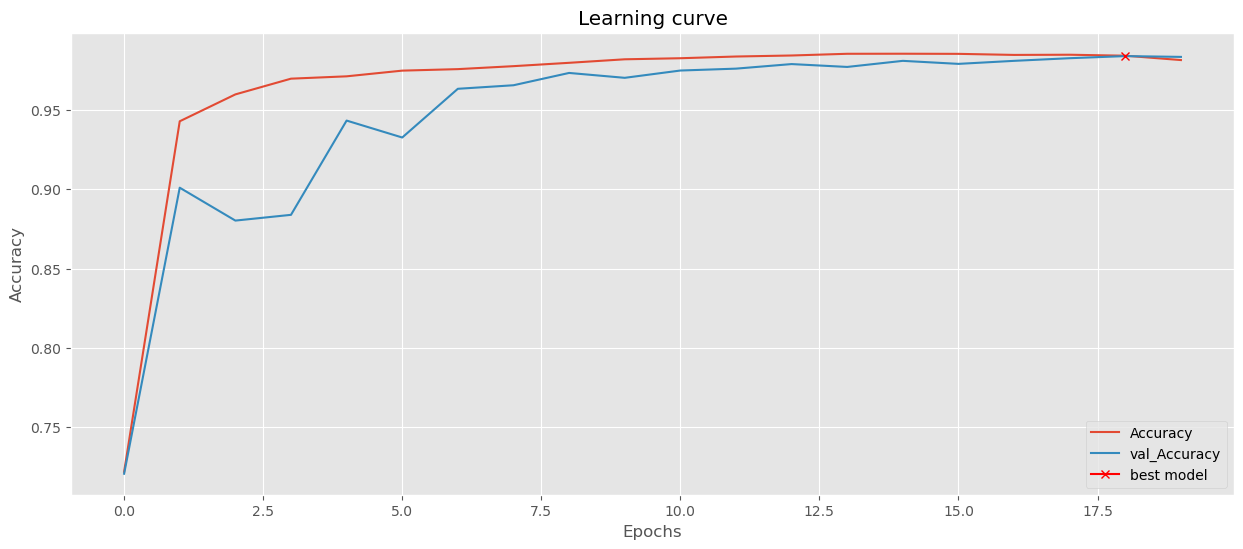

In [13]:
plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["auc"], label="Accuracy")
plt.plot(results.history["val_auc"], label="val_Accuracy")
plt.plot(np.argmax(results.history["val_auc"]), np.max(results.history["val_auc"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

In [14]:
model.load_weights('model-Unet.h5')

In [15]:
model.evaluate(X_test, y_test, verbose=1)

3/3 [==============================] - 0s 82ms/step - loss: -108.4114 - auc: 0.9903


[-108.41139221191406, 0.9903199076652527]

In [16]:
preds = model.predict(X_test, verbose=1)

3/3 [==============================] - 0s 9ms/step


In [17]:
threshold = 1

for i, mask in enumerate(preds):
    mask[mask < threshold] = 0
    mask[mask >= threshold] = 1
    preds[i] = mask

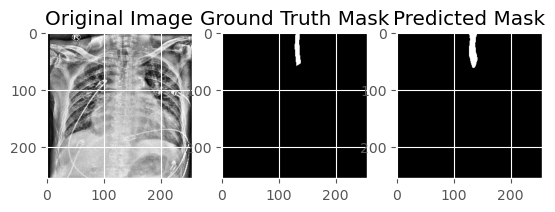

In [18]:
# 顯示原始圖像、原始mask和預測mask(第一張為例)
index = 0

plt.subplot(1, 3, 1)
plt.imshow(X_test[index], cmap='gray')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(y_test[index], cmap='gray')
plt.title('Ground Truth Mask')

plt.subplot(1, 3, 3)
plt.imshow(preds[index], cmap='gray')
plt.title('Predicted Mask')
plt.show()

In [19]:
def iou(y_true, y_pred):
    y_true = y_true.astype(np.bool)
    y_pred = y_pred.astype(np.bool)
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

# 計算預測結果的IOU
iou_score = iou(y_test, preds)

print('IOU: ', iou_score)

IOU:  0.5055491857112643


In [20]:
# 將預測圖像轉換為CV_8UC1格式
z = preds.astype('uint8') * 255

# 執行輪廓檢測
contours, hierarchy = cv2.findContours(z[70], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 找到最大的輪廓
max_contour = max(contours, key=cv2.contourArea)

# 找到最下面的點
bottom_point = tuple(max_contour[max_contour[:,:,1].argmax()][0])

# 輸出端點
print("Bottom point:", bottom_point)

# 繪製輪廓和端點
contour_image = cv2.cvtColor(z[index], cv2.COLOR_GRAY2BGR)
cv2.drawContours(contour_image, [max_contour], -1, (0, 255, 0), 2)
cv2.circle(contour_image, bottom_point, 5, (255, 0, 0), -1)

# 顯示圖像
cv2.imshow('Mask with Contours', contour_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

Bottom point: (129, 83)


In [21]:
# 將預測圖像轉換為CV_8UC1格式
a = y_test.astype('uint8') * 255
b = preds.astype('uint8') * 255

pixels_per_cm = 72  # 72像素1公分
cm_per_pixel = 1 / pixels_per_cm  # 每像素0.0139公分

# 計算所有圖像中最下面端點的誤差（以像素為單位）
total_error = 0
num_error_half = 0
num_error_one = 0
num_images = len(y_test)

for i in range(num_images):
    # 找到原始遮罩中的端點
    contours, _ = cv2.findContours(a[i], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_contour = max(contours, key=cv2.contourArea)
    bottom_point_gt = tuple(max_contour[max_contour[:,:,1].argmax()][0])
    
    # 找到預測遮罩中的端點
    contours, _ = cv2.findContours(b[i], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_contour = max(contours, key=cv2.contourArea)
    bottom_point_pred = tuple(max_contour[max_contour[:,:,1].argmax()][0])
    
    # 計算端點的誤差（以像素為單位）
    error_pixels = np.abs(bottom_point_gt[1] - bottom_point_pred[1])
    
    # 將誤差從像素轉換為公分
    error_cm = error_pixels * cm_per_pixel
    
    # 加入總誤差中
    total_error += error_cm
    
    # 如果誤差<=0.5公分，則將符合條件的樣本數加1
    if error_cm <= 0.5:
        num_error_half += 1
        
    # 如果誤差<=1公分，則將符合條件的樣本數加1
    if error_cm <= 1:
        num_error_one += 1

# 計算平均誤差（以公分為單位）
mean_error_cm = total_error / num_images

# 計算誤差<=0.5公分的準確率
accuracy_half = num_error_half / num_images

# 計算誤差<=1公分的準確率
accuracy_one = num_error_one / num_images

print('平均誤差（公分）:', mean_error_cm)
print('誤差小於等於0.5公分的準確率:', accuracy_half*100, '%')
print('誤差小於等於1公分的準確率:', accuracy_one*100, '%')

平均誤差（公分）: 0.18764775413711587
誤差小於等於0.5公分的準確率: 92.5531914893617 %
誤差小於等於1公分的準確率: 100.0 %
